Importing Requisite Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import math

Prompting the user to enter Overall Heat Transfer Coefficient

In [2]:
U=float(input("Enter your Overall Heat Transfer Coefficient (W/m^2.K): "))

Enter your Overall Heat Transfer Coefficient (W/m^2.K): 125


<ol>
<li>The following cell takes input from the excel sheet and a 'for' loop is run over the range of Tmin from 1°C to 100°C with an interval of 1°C. </li> <br>
<li>The Problem Table algorithm is generated for each value of Tmin. Based on that, Pinch Temperature, Minimum Heating Required, and Minimum Cooling Required is found out. </li> <br>
<li>The following cell also generates Hot Composite Curve and Cold Composite Curve for each value of Tmin. </li> <br> <li>Interpolation is done to get corressponding values of Temperature and Enthalpy wherever slopes of either composite curves changes. </li> <br> <li> This gives us the end temperature points of hot streams and cold streams as well as the Enthalpy Difference. </li> <br> <li> By using LMTD method, we find the area required. Summation is done over all the intervals to get the Total Minimum Area Required. </li> </ol>    

In [3]:
input_table=pd.read_excel('Input Sheet.xlsx')
input_table["Stream Type"]=np.where(input_table["Supply Temperture (°C)"]>input_table["Target Temperature (°C)"],"HOT","COLD")
input_table["Heat Capacity Flowrate (kW/K)"]=round(input_table["Heat Load (kW)"]/(input_table["Target Temperature (°C)"]-input_table["Supply Temperture (°C)"]),2)
#Heat Capacity Flowrate values of all hot streams have been made negative. This convention will be used later to simplify calculations.
index=[]
for n in range(1,len(input_table)+1):
    index.append(n)
input_table["Stream Number"]=index
input_table=input_table.set_index('Stream Number')
input_table=input_table.rename(columns={"Supply Temperture (°C)": "Ts", "Target Temperature (°C)": "Tt", "Heat Capacity Flowrate (kW/K)":"FCp"})
hot_streams=input_table[input_table["Stream Type"]=="HOT"]
cold_streams=input_table[input_table["Stream Type"]=="COLD"]
Tmin=np.linspace(1,100,100)
minimum_total_area_required_in_m2=[]
minimum_hot_utility_required_in_kW=[]
minimum_cold_utility_required_in_kW=[]
pinch_temperature_in_degC=[]
for tmin in Tmin:
    temp_left=cold_streams["Ts"].append(cold_streams["Tt"]).append(round((hot_streams["Ts"]-tmin),2)).append(round((hot_streams["Tt"]-tmin),2)).sort_values(ascending=False) 
    temp_left=list(dict.fromkeys(temp_left)) #this will drop duplicates
    temp_right=hot_streams["Ts"].append(hot_streams["Tt"]).append(round((cold_streams["Ts"]+tmin),2)).append(round((cold_streams["Tt"]+tmin),2)).sort_values(ascending=False) 
    temp_right=list(dict.fromkeys(temp_right)) #this will drop duplicates
    problem_table=pd.DataFrame()
    problem_table["Network"]=[i for i in range(len(temp_right))]
    problem_table["Network"]=problem_table["Network"].astype(str)
    problem_table["Sub"]=np.repeat("SN",len(temp_right))
    problem_table['Subnetwork'] = problem_table['Sub']+problem_table["Network"]
    problem_table=problem_table.drop(["Sub","Network"],axis=1)
    problem_table["Tleft"]=temp_left
    problem_table["Tright"]=temp_right
    streams_involved=np.zeros((len(problem_table),len(input_table)+1),dtype='int')
    cold_streams_involved_1=np.zeros((len(problem_table),len(input_table)+1),dtype='int')
    hot_streams_involved_1=np.zeros((len(problem_table),len(input_table)+1),dtype='int')
    for i in range(len(problem_table)):
        for j in range(len(cold_streams)):
            cold_streams_involved=np.where(cold_streams.iloc[j]["Ts"]<=problem_table.iloc[i]["Tleft"]<cold_streams.iloc[j]["Tt"],cold_streams.iloc[j].name,0)
            streams_involved[i][cold_streams_involved]=cold_streams_involved
            cold_streams_involved_1[i][cold_streams_involved]=cold_streams_involved
        for k in range(len(hot_streams)):
            hot_streams_involved=np.where(hot_streams.iloc[k]["Tt"]<=problem_table.iloc[i]["Tright"]<hot_streams.iloc[k]["Ts"],hot_streams.iloc[k].name,0)
            streams_involved[i][hot_streams_involved]=hot_streams_involved
            hot_streams_involved_1[i][hot_streams_involved]=hot_streams_involved
    problem_table["Streams Involved"]=[streams_involved[i] for i in range(len(problem_table))] 
    difference=[0]
    for i in range(1,len(problem_table)):
        difference.append(problem_table["Tleft"][i-1]-problem_table["Tleft"][i])
    problem_table["Temperature Difference"]=difference
    k=np.zeros(len(problem_table))
    for i in range(len(problem_table)):
        streams=np.extract(problem_table["Streams Involved"][i]!=0, problem_table["Streams Involved"][i]) 
        sum_1=0
        n=len(streams)
        for n in range(len(streams)):
            sum_1=sum_1+input_table.loc[streams[n]]["FCp"] 
        k[i]=sum_1
    problem_table["Summation of FCp"]=k
    problem_table["Deficit"]=problem_table["Summation of FCp"]*problem_table["Temperature Difference"]
    x=[-problem_table["Deficit"].cumsum()[i-1] for i in range(1,len(problem_table))]
    x=np.array(x)
    y=[0]
    y=np.array(y)
    z=np.concatenate((y,x))
    problem_table["Accumulated Input"]=z 
    problem_table["Accumulated Output"]=-problem_table["Deficit"].cumsum() 
    problem_table["Heat Flows Input"]=abs(problem_table["Accumulated Output"].min())+problem_table["Accumulated Input"] 
    problem_table["Heat Flows Output"]=abs(problem_table["Accumulated Output"].min())+problem_table["Accumulated Output"]
    pinch_temp=problem_table[problem_table["Heat Flows Output"]==0.0]["Tright"]
    pinch_temp=pinch_temp.values
    pinch_temp=pinch_temp[0]
    minimum_hot_utility=problem_table.iloc[0]["Heat Flows Input"] 
    minimum_cold_utility=problem_table.iloc[-1]["Heat Flows Output"] 
    hot_composite_curve=pd.DataFrame()
    hot_composite_curve["Temperature"]=problem_table["Tright"].values[::-1]
    hot_composite_curve["Streams Involved"]=[hot_streams_involved_1[len(hot_streams_involved_1)-i-1] for i in range(len(hot_streams_involved_1))]
    k=np.zeros(len(problem_table))
    for i in range(len(problem_table)):
        streams=np.extract(hot_composite_curve["Streams Involved"][i]!=0, hot_composite_curve["Streams Involved"][i]) 
        sum_2=0
        n=len(streams)
        for n in range(len(streams)):
            sum_2=sum_2+input_table.loc[streams[n]]["FCp"] 
        k[i]=sum_2
    hot_composite_curve["Summation of FCp"]=k
    hot_composite_curve["Difference"]=problem_table["Temperature Difference"].values[::-1]
    hot_composite_curve["Enthalpy not Final"]=hot_composite_curve["Difference"]*hot_composite_curve["Summation of FCp"]
    hot_composite_curve["Enthalpy not Final Cumulative"]=hot_composite_curve["Enthalpy not Final"].cumsum()
    final_enthalpy_hot_streams=np.concatenate((0, abs(hot_composite_curve["Enthalpy not Final Cumulative"]).values[:-1]), axis=None)
    x=np.array(final_enthalpy_hot_streams,dtype=np.float)
    y=np.array(hot_composite_curve["Temperature"],dtype=np.float)
    hot_streams; z=hot_streams["Ts"].append(hot_streams["Tt"])
    temp_values_of_hot_streams=np.array(z)
    hot_composite_curve=pd.DataFrame()
    hot_composite_curve["Temperature"]=y
    hot_composite_curve["Final Enthalpy"]=x
    hot_composite_curve=hot_composite_curve[hot_composite_curve['Temperature'].isin(z)]
    cold_composite_curve=pd.DataFrame()
    cold_composite_curve["Temperature"]=problem_table["Tleft"].values[::-1]
    cold_composite_curve["Streams Involved"]=[cold_streams_involved_1[len(cold_streams_involved_1)-i-1] for i in range(len(cold_streams_involved_1))]
    k=np.zeros(len(problem_table))
    for i in range(len(problem_table)):
        streams=np.extract(cold_composite_curve["Streams Involved"][i]!=0, cold_composite_curve["Streams Involved"][i]) 
        sum_3=0
        n=len(streams)
        for n in range(len(streams)):
            sum_3=sum_3+input_table.loc[streams[n]]["FCp"] 
        k[i]=sum_3
    cold_composite_curve["Summation of FCp"]=k
    cold_composite_curve["Difference"]=problem_table["Temperature Difference"].values[::-1]
    cold_composite_curve["Enthalpy not Final"]=cold_composite_curve["Difference"]*cold_composite_curve["Summation of FCp"]
    cold_composite_curve["Enthalpy not Final Cumulative"]=cold_composite_curve["Enthalpy not Final"].cumsum()
    final_enthalpy_cold_streams=np.concatenate((0, abs(cold_composite_curve["Enthalpy not Final Cumulative"]).values[:-1]), axis=None)
    a=np.array(final_enthalpy_cold_streams,dtype=np.float)
    b=np.array(cold_composite_curve["Temperature"],dtype=np.float)
    cold_streams; c=cold_streams["Ts"].append(cold_streams["Tt"])
    temp_values_of_cold_streams=np.array(c)
    cold_composite_curve=pd.DataFrame()
    cold_composite_curve["Temperature"]=b
    cold_composite_curve["Final Enthalpy"]=a+minimum_cold_utility
    cold_composite_curve=cold_composite_curve[cold_composite_curve['Temperature'].isin(c)]
    f = interpolate.interp1d(cold_composite_curve["Final Enthalpy"], cold_composite_curve["Temperature"],bounds_error=False)
    g=interpolate.interp1d(hot_composite_curve["Final Enthalpy"], hot_composite_curve["Temperature"],bounds_error=False)
    extra_temp_hot=g(cold_composite_curve["Final Enthalpy"]);extra_enthalpy_hot=cold_composite_curve["Final Enthalpy"].to_numpy()
    temp={"Temperature":extra_temp_hot,"Final Enthalpy":extra_enthalpy_hot}
    temp2=pd.DataFrame(temp)
    hot_composite_duplicate=pd.concat([hot_composite_curve,temp2])
    hot_composite_duplicate=hot_composite_duplicate.drop_duplicates()
    hot_composite_duplicate=hot_composite_duplicate.sort_values('Final Enthalpy', ascending=True)
    hot_composite_duplicate=hot_composite_duplicate.reset_index(drop=True)
    extra_temp_cold=f(hot_composite_curve["Final Enthalpy"]);extra_enthalpy_cold=hot_composite_curve["Final Enthalpy"].to_numpy()
    temp={"Temperature":extra_temp_cold,"Final Enthalpy":extra_enthalpy_cold}
    temp2=pd.DataFrame(temp)
    cold_composite_duplicate=pd.concat([cold_composite_curve,temp2])
    cold_composite_duplicate=cold_composite_duplicate.drop_duplicates()
    cold_composite_duplicate=cold_composite_duplicate.sort_values('Final Enthalpy', ascending=True)
    cold_composite_duplicate=cold_composite_duplicate.reset_index(drop=True)
    hot_composite_duplicate = hot_composite_duplicate.rename(columns={'Temperature': 'Temperature of Hot Streams','Final Enthalpy': 'Final Enthalpy of Hot Streams'})
    cold_composite_duplicate = cold_composite_duplicate.rename(columns={'Temperature': 'Temperature of Cold Streams','Final Enthalpy':'Final Enthalpy of Cold Streams'})
    minimum_area_calculation=pd.concat([hot_composite_duplicate,cold_composite_duplicate],axis=1)
    minimum_area_calculation=minimum_area_calculation.drop(['Final Enthalpy of Hot Streams'],axis=1)
    minimum_area_calculation=minimum_area_calculation.rename(columns={'Final Enthalpy of Cold Streams':'Final Enthalpy of either streams'})
    minimum_area_calculation=minimum_area_calculation.dropna()
    minimum_area_calculation=minimum_area_calculation.drop_duplicates(subset='Final Enthalpy of either streams')
    summation=[]
    for n in range(len(minimum_area_calculation)-1):
        deltaTa=minimum_area_calculation["Temperature of Hot Streams"].iloc[n+1]-minimum_area_calculation["Temperature of Cold Streams"].iloc[n+1]
        deltaTb=minimum_area_calculation["Temperature of Hot Streams"].iloc[n]-minimum_area_calculation["Temperature of Cold Streams"].iloc[n]
        if deltaTa==deltaTb:
            LMTD=deltaTa
        else:
            LMTD=abs(deltaTa-deltaTb)/abs(math.log(abs(deltaTa/deltaTb)))
        deltaH=minimum_area_calculation["Final Enthalpy of either streams"].iloc[n+1]-minimum_area_calculation["Final Enthalpy of either streams"].iloc[n]
        summation.append(deltaH/LMTD)
    final_summation=sum(summation)
    minimum_total_area_required_in_m2.append(final_summation*1000/(U))
    minimum_hot_utility_required_in_kW.append(minimum_hot_utility)
    minimum_cold_utility_required_in_kW.append(minimum_cold_utility)
    pinch_temperature_in_degC.append(pinch_temp)

<br> Exporting the necessary data into a Pandas DataFrame <br>

In [4]:
optimize=pd.DataFrame()
optimize["DeltaTmin"]=Tmin
optimize["Pinch Temperature"]=pinch_temperature_in_degC
optimize["Ideal Minimum Hot Utility Required"]=minimum_hot_utility_required_in_kW
optimize["Ideal Minimum Cold Utility Required"]=minimum_cold_utility_required_in_kW
optimize["Ideal Minimum Area Required"]=minimum_total_area_required_in_m2

Code to draw graph of Minimum Area vs Minimum Hot Utility

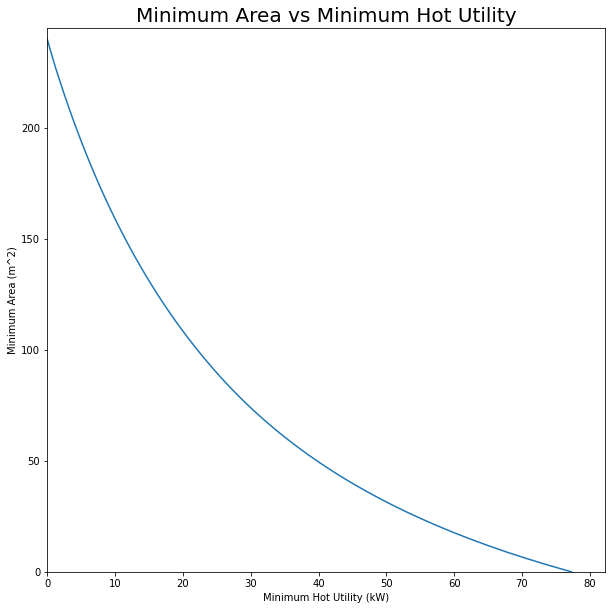

In [5]:
plt.figure(figsize=(10,10))
plt.ylim(0,optimize["Ideal Minimum Hot Utility Required"].max()+5)
plt.xlim(0,optimize["Ideal Minimum Area Required"].max()+5)
plt.plot(optimize["Ideal Minimum Area Required"],optimize["Ideal Minimum Hot Utility Required"])
plt.xlabel("Minimum Hot Utility (kW)")
plt.ylabel("Minimum Area (m^2)")
plt.title("Minimum Area vs Minimum Hot Utility",fontsize=20)
plt.savefig("Minimum Area vs Minimum Hot Utility.png", dpi=300, bbox_inches="tight")
plt.show()

Code to draw graph of Minimum Area vs ΔTmin

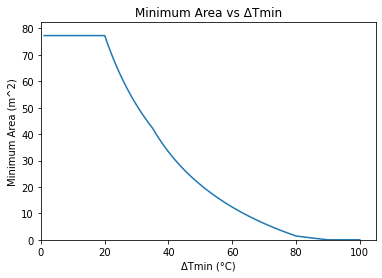

In [6]:
plt.xlim(0,105)
plt.ylim(0,optimize["Ideal Minimum Area Required"].max()+5)
plt.plot(optimize["DeltaTmin"],optimize["Ideal Minimum Area Required"])
plt.xlabel("ΔTmin (°C)")
plt.ylabel("Minimum Area (m^2)")
plt.title("Minimum Area vs ΔTmin")
plt.savefig("Minimum Area vs ΔTmin.png", dpi=300, bbox_inches="tight")
plt.show()

Code to graph of Minimum Utility vs ΔTmin

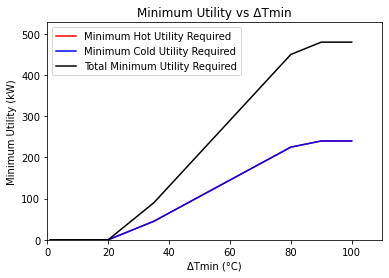

In [7]:
plt.ylim(0,1.1*(optimize["Ideal Minimum Hot Utility Required"].max()+optimize["Ideal Minimum Cold Utility Required"].max()))
plt.xlim(0,110)
plt.plot(optimize["DeltaTmin"],optimize["Ideal Minimum Hot Utility Required"],color='red',label='Minimum Hot Utility Required')
plt.plot(optimize["DeltaTmin"],optimize["Ideal Minimum Cold Utility Required"],color='blue',label='Minimum Cold Utility Required')
plt.plot(optimize["DeltaTmin"],optimize["Ideal Minimum Cold Utility Required"]+optimize["Ideal Minimum Hot Utility Required"],color='black',label='Total Minimum Utility Required')
plt.xlabel("ΔTmin (°C)")
plt.ylabel("Minimum Utility (kW)")
plt.title("Minimum Utility vs ΔTmin")
plt.legend()
plt.savefig("Minimum Utility vs ΔTmin.png", dpi=300, bbox_inches="tight")
plt.show()

Renaming the columns of Pandas DataFrame to include units in final output

In [8]:
optimize=optimize.rename(columns={"DeltaTmin":"ΔTmin (°C)","Pinch Temperature":"Pinch Temperature (°C)","Ideal Minimum Hot Utility Required":"Ideal Minimum Heating Required (kW)","Ideal Minimum Cold Utility Required":"Ideal Minimum Cooling Required (kW)",
                "Ideal Minimum Area Required":"Ideal Minimum Area Required (m^2)"})

The final Pandas DataFrame

In [9]:
optimize

,ΔTmin (°C),Pinch Temperature (°C),Ideal Minimum Heating Required (kW),Ideal Minimum Cooling Required (kW),Ideal Minimum Area Required (m^2)
0,1.0,170.0,0.0,0.0,77.278764
1,2.0,170.0,0.0,0.0,77.278764
2,3.0,170.0,0.0,0.0,77.278764
3,4.0,170.0,0.0,0.0,77.278764
4,5.0,170.0,0.0,0.0,77.278764
...,...,...,...,...,...
95,96.0,176.0,240.0,240.0,0.000000
96,97.0,177.0,240.0,240.0,0.000000
97,98.0,178.0,240.0,240.0,0.000000
98,99.0,179.0,240.0,240.0,0.000000


Exporting the Pandas Dataframe to an Excel Sheet

In [10]:
writer = pd.ExcelWriter('Optimization of ΔTmin.xlsx',engine='xlsxwriter')   
workbook=writer.book
worksheet=workbook.add_worksheet('Sheet 1')
writer.sheets['Sheet 1'] = worksheet
optimize.to_excel(writer,sheet_name='Sheet 1',startrow=0 , startcol=0)   
writer.save()